# Part 0: Setup

In [160]:
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install numpy
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Part 1: Data understanding

## Loading, processing and exploring data

In [162]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(train.info())
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

In [163]:
print(train.head(5))
print(train.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Pa

In [164]:
train['Embarked']=train['Embarked'].fillna('Unknown')
train['Embarked']=train['Embarked'].astype('category')

test['Embarked']=test['Embarked'].fillna('Unknown')
test['Embarked']=test['Embarked'].astype('category')

train['Sex']=train['Sex'].astype('category')
test['Sex']=test['Sex'].astype('category')

train = train.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'])
gender_submission = test['PassengerId']
test = test.drop(columns=['Cabin', 'Name', 'Ticket', 'PassengerId'])

train['Age'] = train['Age'].fillna(train['Age'].mean())
test['Age'] = test['Age'].fillna(test['Age'].mean())


In [165]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    int64   
 2   Sex       891 non-null    category
 3   Age       891 non-null    float64 
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Fare      891 non-null    float64 
 7   Embarked  891 non-null    category
dtypes: category(2), float64(2), int64(4)
memory usage: 44.0 KB
None


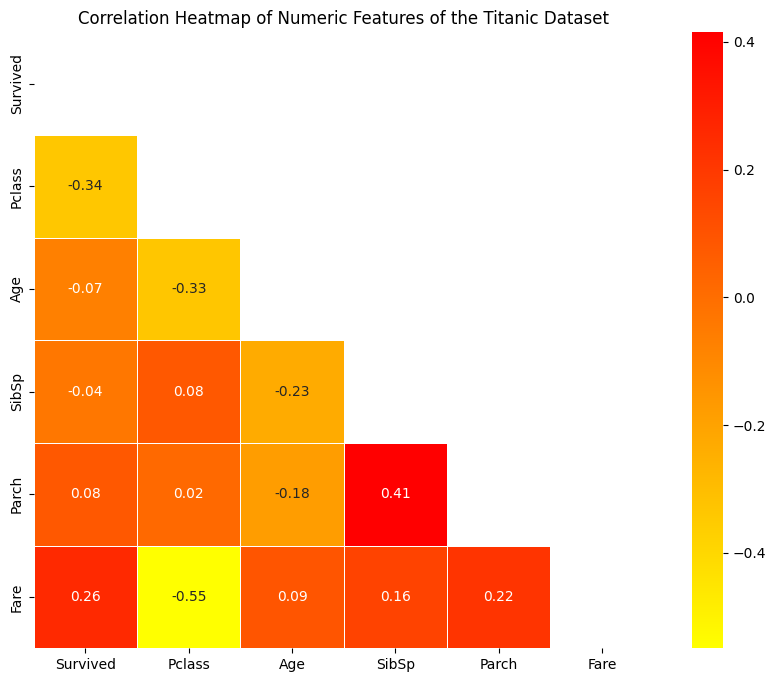

In [166]:
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = train[numeric_cols].corr()

plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) # The upper part of the matrix may confuse poor Albert

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='autumn_r', linewidths=0.5)

plt.title('Correlation Heatmap of Numeric Features of the Titanic Dataset')
#plt.show()
plt.savefig('visu.png', bbox_inches='tight')

# Part 2: Modeling

In [167]:
categorical_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Categorical columns:", categorical_cols)

combined_data = pd.concat([train, test], keys=['train', 'test'])

combined_data = pd.get_dummies(combined_data, columns=categorical_cols)

train_data_encoded = combined_data.xs('train')
train_x = train_data_encoded.drop(columns='Survived')
train_y = train_data_encoded['Survived']
test_data_encoded = combined_data.xs('test')
test_x = test_data_encoded.drop(columns='Survived')
test_y = test_data_encoded['Survived']


Categorical columns: ['Sex', 'Embarked']


In [168]:
test_data_encoded.isna().sum()

Survived            418
Pclass                0
Age                   0
SibSp                 0
Parch                 0
Fare                  1
Sex_female            0
Sex_male              0
Embarked_C            0
Embarked_Q            0
Embarked_S            0
Embarked_Unknown      0
dtype: int64

In [182]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=63)
rf_model.fit(train_x, train_y)


RandomForestClassifier(n_estimators=200, random_state=63)

In [183]:
importances = rf_model.feature_importances_
feature_names = train_x.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print("Top 10 Feature Importances:")
print(feature_importance_df.head(10))

Top 10 Feature Importances:
      Feature  Importance
1         Age    0.258916
4        Fare    0.253615
6    Sex_male    0.148822
5  Sex_female    0.135598
0      Pclass    0.086738
2       SibSp    0.047704
3       Parch    0.036671
9  Embarked_S    0.012881
7  Embarked_C    0.011606
8  Embarked_Q    0.007361


In [186]:
y_pred = rf_model.predict(test_x)
result = pd.DataFrame(gender_submission.copy())
result['Survived'] = [int(pred) for pred in list(y_pred)]
print(type(result))
result.describe()

<class 'pandas.core.frame.DataFrame'>


,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.346890
std,120.810458,0.476551
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [187]:
result.to_csv('data/gender_submission.csv', index=False)